## Bayesian model reduction for deep learning

Let us start with the following full generative model with normal priors over network parameters

\begin{equation}
    \begin{split}
        b_{li} &\sim \mathcal{N}\left(0, 1 \right) \\
        \omega_{lij} &\sim \mathcal{N}\left(0, 1 \right) \\
        y_n &\sim p\left(y| \pmb{W}, \pmb{X}_n  \right)
    \end{split}
\end{equation}

We look for the posterior in the form 
\begin{equation}
    \begin{split}
        p\left( \pmb{b}, \pmb{W}|\pmb{\mathcal{D}}\right) & \approx \prod_l \prod_i q\left(\pmb{b}_{li} \right) \prod_j q\left( \omega_{lij} \right)  \\
        q\left(\pmb{b}_{li} \right) &= \mathcal{N}\left(\pmb{\mu}_{li}^b, [\sigma^b_{li}]^2 \right) \\
        q\left( \pmb{W}_{li} \right) &= \mathcal{N}_{kt} \left( \pmb{\mu}_{lij}^\omega, \pmb{\pi}^{-1}_{lij}  \right)
    \end{split}
\end{equation}

The extended model introduces the following hierarchical prior over network weights

\begin{equation}
    \begin{split}
        c_l^2 &\sim \Gamma\left(2, 2 \right) \\
        \tau_{li} &\sim \mathcal{C}^{+}(0, 1) \\
        \lambda_{lij} &\sim \mathcal{C}^{+}(0, 1) \\
        \gamma^2_{lij} & = \frac{c_l^2 \tau^2_{li}\lambda^2_{lij}}{c_l^2 + \tau^2_{li}\lambda^2_{lij} } \\
        \omega_{lij} &\sim \mathcal{N}\left(0, \gamma^2_{lij} \right)
    \end{split}
\end{equation}

The change in the variational free energy is obtained as 

\begin{equation}
    \begin{split}
        \tilde{\pi}_{lij} &= \pi_{lij} + \gamma^{-2}_{lij} - \pi_0 \\
        \tilde{\mu}_{lij} &= \tilde{\pi}_{lij}^{-1} \pi_{lij} \mu_{lij} \\
        \Delta F\left( G \right) &= \ln E_{q(\pmb{W})}\left[ \frac{\tilde{p}(\pmb{W}| \pmb{G})}{p(\pmb{W})}\right] \\

        &= \frac{1}{2}\sum_{lij} \left[ \ln \left(\gamma^{-2}_{lij} \pi_{lij} \tilde{\pi}^{-1}_{lij}\right)  - \mu_{lij}^2 \pi_{lij} + \tilde{\mu}^2_{lij}\tilde{\pi}_{lij} \right]\\
        &= \frac{1}{2}\sum_{lij} \left[ - \ln\left( \gamma_{lij}^2 + \sigma^2_{lij} - \pi_0 \gamma_{lij}^2 \sigma^2_{lij}\right) - \mu_{lij}^2\pi_{lij}\left(1 - \tilde{\pi}_{lij}^{-1} \pi_{lij} \right) \right] \\
    \end{split}
\end{equation}


where $ \pmb{G}_{lij} = \pmb{\gamma}^2_{lij}$.

In [1]:
import os
# Set cuda device to use
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# do not prealocate memory
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import numpy as np
import jax.numpy as jnp
from jax import random, vmap, nn, lax, devices, device_put
from jax.nn import one_hot
import matplotlib.pyplot as plt
import seaborn as sns

from numpyro.infer import Predictive
from functools import partial
from models import BayesRegression, SVIRegression, BMRRegression
from networks import MLP

print(devices('gpu'), devices('cpu'))
rng_key = random.PRNGKey(0)
sns.set_theme(context='notebook', style='white', font_scale=1.6, color_codes=True)

[StreamExecutorGpuDevice(id=0, process_index=0, slice_index=0)] [CpuDevice(id=0)]


In [4]:
from numpc.datasets import load_data

# load data
train_ds, test_ds = load_data('fashion_mnist')

train_ds['image'] = train_ds['image'].squeeze().reshape(train_ds['image'].shape[0], -1)
test_ds['image'] = test_ds['image'].squeeze().reshape(test_ds['image'].shape[0], -1)

_, in_size = train_ds['image'].shape
out_size = len(jnp.unique(train_ds['label']))

# number of neurons in hidden layer
num_hn = [50, 100, 200, 300, 400, 500]

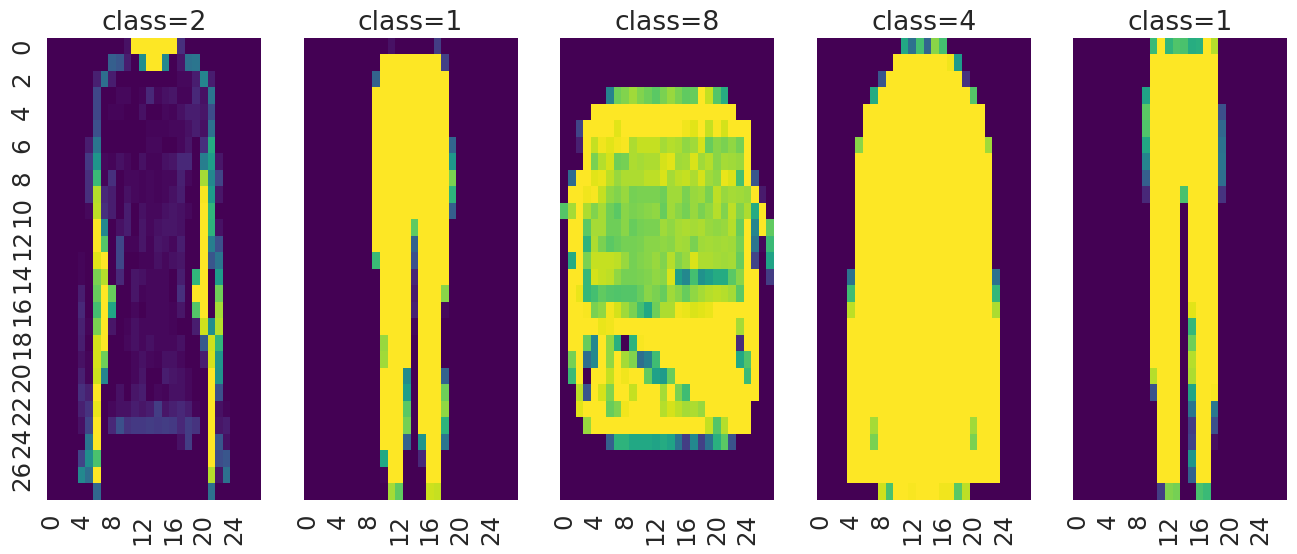

In [5]:
# normalising 
n, d = train_ds['image'].shape
mean = train_ds['image'].mean()
std = train_ds['image'].std()
train_ds['image'] = lax.stop_gradient((train_ds['image'] - mean) / std)
test_ds['image'] = lax.stop_gradient((test_ds['image'] - mean) / std)

X = train_ds['image'] 
X_test = test_ds['image']

in_size = X.shape[1]

fig, axes = plt.subplots(1, 5, figsize=(16, 6), sharex=True, sharey=True)

for n in range(5):
    sns.heatmap(train_ds['image'][n].reshape(28, 28), cmap='viridis', ax = axes[n], cbar=False, vmax=1., vmin=0.)
    axes[n].set_title('class={}'.format(train_ds['label'][n]))

fig.savefig('Fig4.png', bbox_inches='tight', transparent=True,  dpi=300)

In [6]:
import tensorflow_probability.substrates.jax.stats as stats
import tensorflow as tf
from numpyro.infer import log_likelihood

def compression(L, samples, cuttoff=1.):
    compressed_smpl = samples.copy()
    nonzero = 0
    count = 0
    for l in range(L):
        mu = samples[f'layer{l}.weight'].mean(0)
        std = samples[f'layer{l}.weight'].std(0)
        z = mu/std
        mask = jnp.abs(z) > cuttoff
        nonzero += mask.sum()
        count += z.shape[0] * z.shape[1]
        compressed_smpl[f'layer{l}.weight'] = samples[f'layer{l}.weight'] * mask
        compressed_smpl[f'layer{l}.weight_base'] = samples[f'layer{l}.weight_base'] * mask

    return compressed_smpl, 1 - nonzero/count

def compression_svi(L, samples, cuttoff=1.):
    compressed_smpl = samples.copy()
    nonzero = 0
    count = 0
    for l in range(L):
        _, i, j = samples[f'layer{l}.weight'].shape
        mask = (samples[f'layer{l}.weight.gamma'] < cuttoff * 1e-2).mean(0) <= 0.9
        
        compressed_smpl[f'layer{l}.weight'] = samples[f'layer{l}.weight'] * mask
        compressed_smpl[f'layer{l}.weight_base'] = samples[f'layer{l}.weight_base'] * mask

        if l < L -1:
            nonzero += jnp.broadcast_to(mask, (i, j)).sum()
            count += i * j
        

    return compressed_smpl, 1 - nonzero/count

def compression_map(L, samples, cuttoff=1e-3):
    compressed_smpl = samples.copy()
    nonzero = 0
    count = 0
    for l in range(L):
        mu = samples[f'layer{l}.weight'].mean(0)
        z = mu
        mask = jnp.abs(z) > cuttoff
        nonzero += mask.sum()
        count += z.shape[0] * z.shape[1]
        compressed_smpl[f'layer{l}.weight'] = samples[f'layer{l}.weight'] * mask
        compressed_smpl[f'layer{l}.weight_base'] = samples[f'layer{l}.weight_base'] * mask

    return compressed_smpl, 1 - nonzero/count

def mean_ll(log_like):

    S = log_like.shape[0]
    ll = nn.logsumexp(log_like - jnp.log(S), axis=0) 
    lpd = nn.logsumexp(log_like.sum(-1) - jnp.log(S))

    return ll, lpd 

def test_smpl(rng_key, model, sample, labels):
    pred = Predictive(model, posterior_samples=sample, parallel=True, return_sites=['obs', 'probs'])

    ll = log_likelihood(model, sample, parallel=True, obs=labels)

    ll, lpd = mean_ll(ll['obs'])

    rng_key, _rng_key = random.split(rng_key)
    pred_sample = pred(_rng_key)

    probs = pred_sample['probs'].mean(0)
    pred_labels = probs.argmax(-1)

    hit = pred_labels == labels
    acc = hit.mean(-1)

    ece = stats.expected_calibration_error_quantiles(
            hit, tf.math.log(probs.max(-1)), num_buckets=20
        )

    return {
        'ece': ece[0],
        'acc': acc,
        'nll': -ll.mean(),
        'lpd': lpd.item(),
    }

In [7]:
def iterate_through_cuttoffs(rng_key, regmodel, smpl, method='MAP', cuttoffs=[0, 1, 2, 3, 4, 5, 6]):
    results = {
        'cuttoffs': cuttoffs,
        'zips': [],
        'accs': [],
        'eces': [],
        'lpds': [],
        'nlls': []
    }
    for c in cuttoffs:
        if method =='MAP':
            compressed_smpl, fraction =  compression_map(len(regmodel.layers), smpl, cuttoff=c * 1e-2)
        else:
            compressed_smpl, fraction =  compression(len(regmodel.layers), smpl, cuttoff=c * 0.5)

        rng_key, _rng_key = random.split(rng_key)
        out = test_smpl(_rng_key, regmodel.model, compressed_smpl, test_ds['label'])
        results['zips'].append(fraction)
        results['accs'].append(out['acc'])
        results['eces'].append(out['ece'])
        results['lpds'].append(out['lpd']/len(test_ds['label']))
        results['nlls'].append(out['nll'])
    
    return results

def loopy_bmr(rng_key, y, nnet, opts, posterior='normal', autoguide='mean-field', reduced=False):

    rng_key, _rng_key = random.split(rng_key)
    bmr_reg = BMRRegression(
        _rng_key, 
        X, 
        nnet, 
        regtype='multinomial',
        batch_size=opts['batch_size'],
        posterior=posterior,
        gamma0=opts['gamma0'],
        tau0=opts['tau0'],
        reduced=reduced
    )

    losses = []

    for e in range(opts['epochs']):
        bmr_reg.set_input(X, opts['batch_size'])
        
        bmr_reg.fit(
            y, 
            num_samples=1, 
            num_steps=opts['num_steps1'],
            num_particles=opts['num_particles'],
            progress_bar=True,
            opt_kwargs={'learning_rate': opts['lr']}
        )
        bmr_reg.samples.pop('obs')

        results, smpl = bmr_reg.bmr(
            autoguide, 
            num_steps=opts['num_steps2'], 
            progress_bar=True,
            num_particles=opts['num_particles'], 
            num_samples=opts['num_samples'],
            opt_kwargs={'learning_rate': opts['lr']} 
        )

        losses.append((bmr_reg.results.losses, results.losses))

        smpl.pop('obs')
        bmr_reg.set_input(X_test)

        rng_key, _rng_key = random.split(rng_key)
        out = test_smpl(_rng_key, bmr_reg.model, smpl, test_ds['label'])
        out['DF'] = results.losses[-1000:-500].mean() - results.losses[-500:].mean()
        
        print(out['DF'], out['lpd'], out['acc'], out['ece'])
    
    measurments = iterate_through_cuttoffs(rng_key, bmr_reg, smpl, method='BMR')
    return measurments, smpl, losses

def posterior_estimate(rng_key, depth, width_size, regression, opts, posterior='normal', reduced=False, method='MAP', **kwargs):
    rng_key, _rng_key = random.split(rng_key)
    dense_net = MLP(in_size, out_size=out_size, width_size=width_size, depth=depth, key=_rng_key)

    rng_key, _rng_key = random.split(rng_key)
    regmodel = regression(
        _rng_key, 
        X, 
        dense_net, 
        regtype='multinomial',
        batch_size=opts['batch_size'],
        posterior=posterior,
        gamma0=opts['gamma0'],
        tau0=opts['tau0'],
        reduced=reduced
    )
    
    smpl = regmodel.fit(
        train_ds['label'], 
        num_samples=opts['num_samples'], 
        num_steps=opts['num_steps'],
        num_particles=opts['num_particles'],
        progress_bar=True,
        opt_kwargs={'learning_rate': opts['lr']},
        **kwargs
    )

    smpl.pop('obs')
    regmodel.set_input(X_test)

    rng_key, _rng_key = random.split(rng_key)
    out = test_smpl(_rng_key, regmodel.model, smpl, test_ds['label'])
    out['DF'] = regmodel.results.losses[-10000:-5000].mean() - regmodel.results.losses[-5000:].mean()
    print(depth, width_size, out['DF'], out['lpd'], out['acc'], out['ece'])

    measurments = iterate_through_cuttoffs(rng_key, regmodel, smpl, method=method)

    return measurments, smpl, regmodel.results.losses

In [8]:
try:
    res = jnp.load('comp_images.npz', allow_pickle=True)['results'].item()
except:   
    res = {
        'MAP': [],
        'SVI-STR': [],
        'SVI-FF': [],
        'Flat-STR': [],
        'Flat-FF': [],
        'BMR-STR': [],
        'BMR-FF': []
    }

try:
    res.pop('NUTS')
    res.pop('BMR')
    res.pop('No-BMR')
except:
    pass

100%|██████████| 100000/100000 [01:24<00:00, 1189.42it/s, init loss: 85967.5625, avg. loss [95001-100000]: -38441.7773]


1 50 83.609375 -3296.50732421875 0.8857 0.01125121


100%|██████████| 100000/100000 [01:09<00:00, 1439.17it/s, init loss: 32734.2031, avg. loss [95001-100000]: -94653.2812]


1 100 57.953125 -3119.67529296875 0.8903 0.012606943


100%|██████████| 100000/100000 [01:23<00:00, 1196.00it/s, init loss: -73505.6406, avg. loss [95001-100000]: -205317.8750]


1 200 9.625 -2960.42333984375 0.8962 0.009111326


100%|██████████| 100000/100000 [01:16<00:00, 1308.12it/s, init loss: -176765.3438, avg. loss [95001-100000]: -315486.8750]


1 300 -10.28125 -2947.802734375 0.89699996 0.01071635


100%|██████████| 100000/100000 [01:35<00:00, 1050.39it/s, init loss: -287274.4375, avg. loss [95001-100000]: -425589.7188]


1 400 24.53125 -2954.8369140625 0.8961 0.012115015


100%|██████████| 100000/100000 [01:20<00:00, 1235.92it/s, init loss: -391808.8750, avg. loss [95001-100000]: -535621.5625]


1 500 16.75 -2931.26611328125 0.89739996 0.010653557


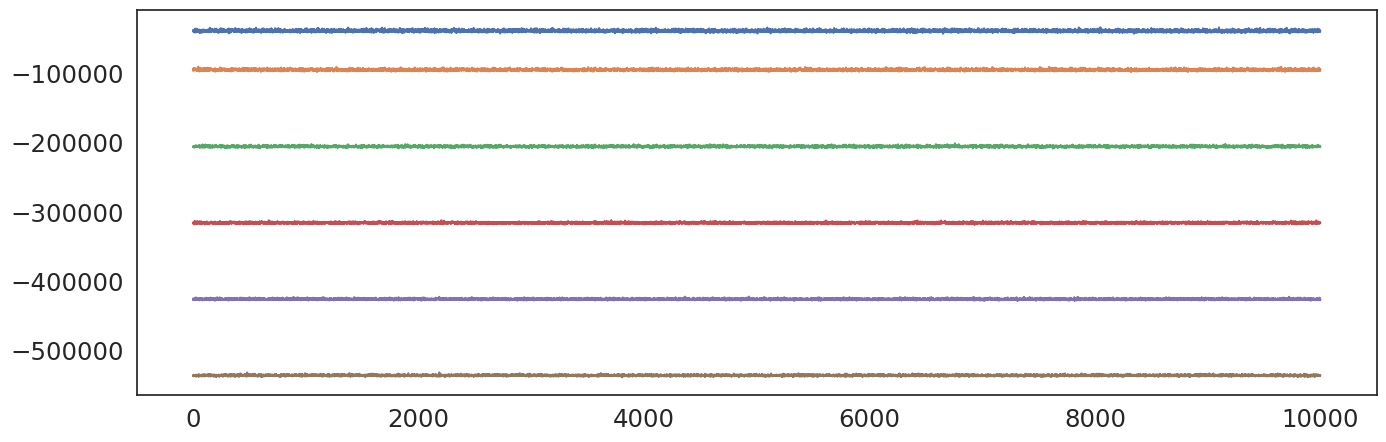

In [12]:
depth = 1
method = 'MAP'
res[method] = []
opts = {
    'num_steps': 100_000,
    'batch_size': 512,
    'num_samples': 1,
    'num_particles': 1,
    'lr': 1e-4,
    'gamma0': 0.1,
    'tau0': 1.  # irrelevant param
}

losses = []
for width_size in num_hn:
    rng_key, _rng_key = random.split(rng_key)
    measurments, smpl, loss = posterior_estimate(rng_key, depth, width_size, BMRRegression, opts, posterior='delta', method=method)
    losses.append(loss)
    res[method].append( (depth, width_size, measurments, opts, smpl) )

jnp.savez('comp_images.npz', results=res)
plt.figure(figsize=(16, 5))
for loss in losses:
    plt.plot(loss[-10_000:])

100%|██████████| 200000/200000 [15:06<00:00, 220.67it/s, init loss: 302375.5625, avg. loss [190001-200000]: 22706.7832]


1 50 6.5546875 -3586.260498046875 0.89229995 0.014071035


100%|██████████| 200000/200000 [16:35<00:00, 200.93it/s, init loss: 466643.5000, avg. loss [190001-200000]: 23987.1875]


1 100 10.871094 -3554.625244140625 0.88879997 0.018237114


100%|██████████| 200000/200000 [19:20<00:00, 172.40it/s, init loss: 793468.6250, avg. loss [190001-200000]: 25295.9004]


1 200 12.517578 -3657.89404296875 0.88689995 0.022526478


100%|██████████| 200000/200000 [21:05<00:00, 158.07it/s, init loss: 1120970.8750, avg. loss [190001-200000]: 26112.6660]


1 300 6.9433594 -3733.946533203125 0.88549995 0.023116395


100%|██████████| 200000/200000 [25:05<00:00, 132.81it/s, init loss: 1449338.8750, avg. loss [190001-200000]: 26697.8379]


1 400 4.3652344 -3720.30029296875 0.8824 0.02383723


100%|██████████| 200000/200000 [27:30<00:00, 121.16it/s, init loss: 1777108.6250, avg. loss [190001-200000]: 27172.2637]


1 500 -1.625 -3727.52783203125 0.8818 0.025081865


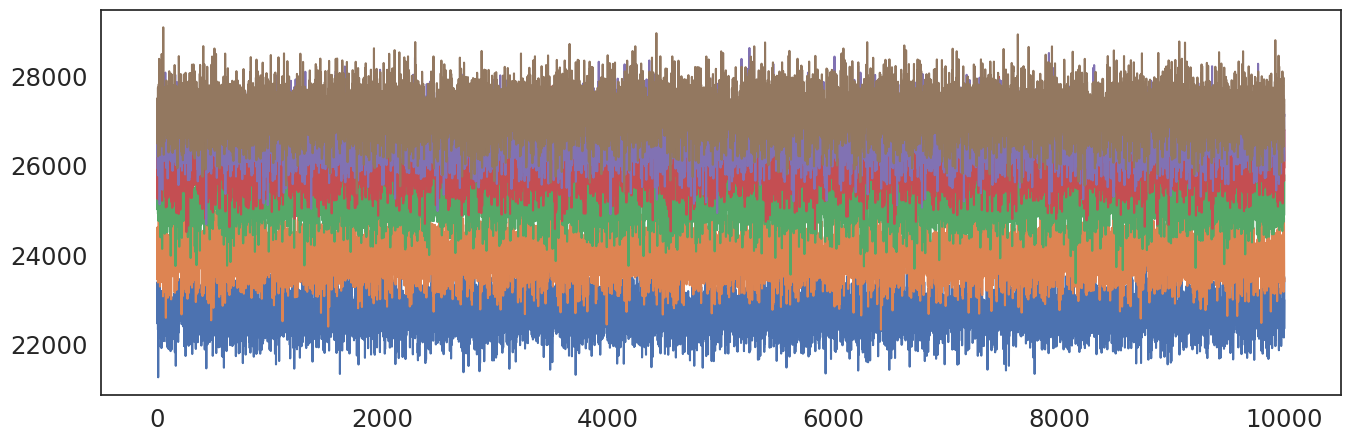

In [15]:
method = 'SVI-STR'
depth = 1

res[method] = []
opts = {
    'num_steps': 200_000,
    'batch_size': 512,
    'num_samples': 100,
    'num_particles': 16,
    'lr': 1e-3,
    'tau0': 1e-2,
    'gamma0': 1. # irrelevant param  
}

losses = []
for width_size in num_hn:
    rng_key, _rng_key = random.split(rng_key)
    measurements, smpl, loss = posterior_estimate(
        rng_key, depth, width_size, SVIRegression, opts, reduced=False, method=method, autoguide='structured'
    )
    losses.append(loss)
    res[method].append( (depth, width_size, measurements, opts, smpl) )

jnp.savez('comp_images.npz', results=res)
plt.figure(figsize=(16, 5))
for loss in losses:
    plt.plot( loss[-10_000:] )

100%|██████████| 200000/200000 [11:31<00:00, 289.03it/s, init loss: 700218.1250, avg. loss [190001-200000]: 25530.8789]


1 50 20.109375 -4015.843017578125 0.86429995 0.0075251255


100%|██████████| 200000/200000 [12:44<00:00, 261.47it/s, init loss: 2262922.7500, avg. loss [190001-200000]: 25686.6211]


1 100 2.203125 -3827.126220703125 0.8696 0.009220731


100%|██████████| 200000/200000 [15:04<00:00, 221.03it/s, init loss: 55563304.0000, avg. loss [190001-200000]: 25963.4102]


1 200 18.96289 -3867.426025390625 0.8657 0.0076773493


100%|██████████| 200000/200000 [14:13<00:00, 234.21it/s, init loss: 14978906.0000, avg. loss [190001-200000]: 25824.6387]


1 300 11.0390625 -3917.23291015625 0.8674 0.012600783


100%|██████████| 200000/200000 [16:59<00:00, 196.11it/s, init loss: 10885016.0000, avg. loss [190001-200000]: 25762.9688]


1 400 20.65039 -3795.93798828125 0.8727 0.00651887


  0%|          | 0/200000 [00:00<?, ?it/s]2023-04-19 20:13:40.450264: E external/xla/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 1s:

  reduce.2943 (displaying the full instruction incurs a runtime overhead. Raise your logging level to 4 or above).

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2023-04-19 20:13:40.460262: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.010075745s
Constant folding an instruction is taking > 1s:

  reduce.2943 (displaying the full instruction incurs a runtime overhead. Raise your logging level to 4 or above).

This isn't necessarily a bug;

1 500 13.175781 -3898.664794921875 0.8667 0.010959106


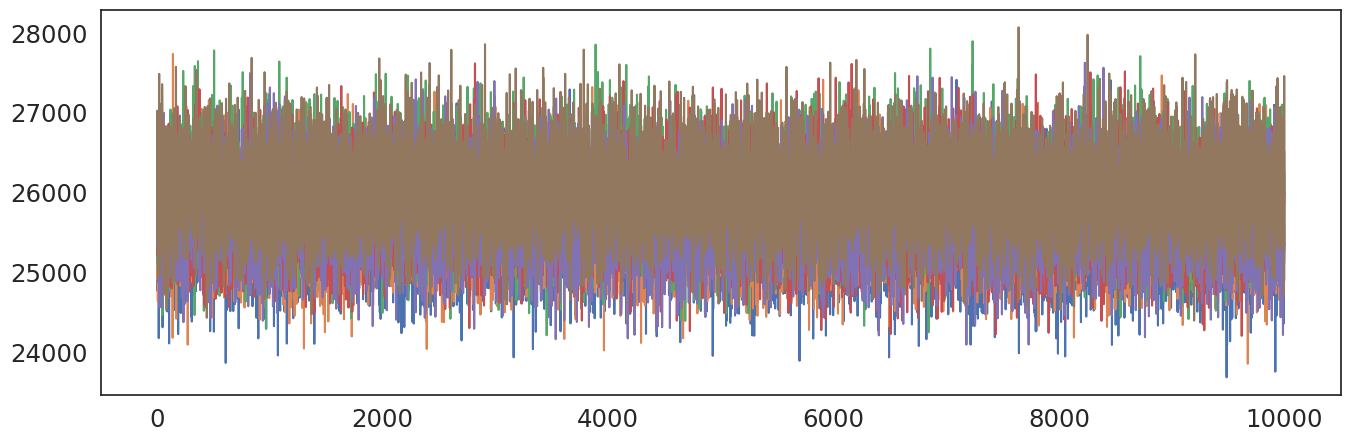

In [16]:
method = 'SVI-FF'
depth = 1

res[method] = []
opts = {
    'num_steps': 200_000,
    'batch_size': 512,
    'num_samples': 100,
    'num_particles': 16,
    'lr': 1e-3,
    'tau0': 1e-2,
    'gamma0': 1. # irrelevant param  
}

losses = []
for width_size in num_hn:
    rng_key, _rng_key = random.split(rng_key)
    measurements, smpl, loss = posterior_estimate(
        rng_key, depth, width_size, SVIRegression, opts, reduced=False, method=method, autoguide='mean-field'
    )
    losses.append(loss)
    res[method].append( (depth, width_size, measurements, opts, smpl) )

jnp.savez('comp_images.npz', results=res)
plt.figure(figsize=(16, 5))
for loss in losses:
    plt.plot( loss[-10_000:] )

100%|██████████| 200000/200000 [10:21<00:00, 321.71it/s, init loss: 210147.9844, avg. loss [190001-200000]: 28873.0410]


1 50 -6.03125 -3972.50390625 0.8675 0.0283284


100%|██████████| 200000/200000 [11:14<00:00, 296.50it/s, init loss: 282432.2500, avg. loss [190001-200000]: 29324.7461]


1 100 -5.720703 -3954.247802734375 0.8691 0.032221276


100%|██████████| 200000/200000 [12:11<00:00, 273.33it/s, init loss: 426946.8125, avg. loss [190001-200000]: 30093.7422]


1 200 14.28125 -3953.408447265625 0.8673 0.029470192


100%|██████████| 200000/200000 [12:44<00:00, 261.51it/s, init loss: 570466.7500, avg. loss [190001-200000]: 30997.9316]


1 300 9.625 -3998.611083984375 0.8677 0.02830975


100%|██████████| 200000/200000 [14:34<00:00, 228.83it/s, init loss: 714801.3125, avg. loss [190001-200000]: 31863.5117]


1 400 -16.066406 -4057.9560546875 0.8695 0.028503487


100%|██████████| 200000/200000 [15:23<00:00, 216.52it/s, init loss: 858673.6250, avg. loss [190001-200000]: 32675.9883]


1 500 -0.74609375 -4055.421142578125 0.86899996 0.030326372


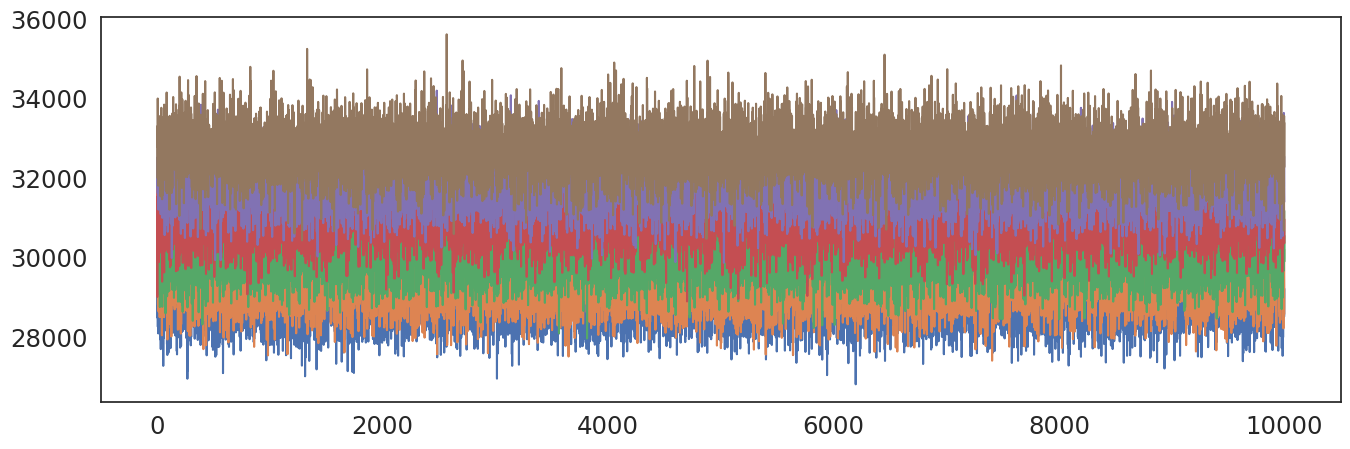

In [9]:
depth = 1
method = 'Flat-FF'

res[method] = []
opts = {
    'num_steps': 200_000,
    'batch_size': 512,
    'num_samples': 100,
    'num_particles': 16,
    'lr': 1e-3,
    'gamma0': 0.1,
    'tau0': 1.  # irrelevant param
}

losses = []
for width_size in num_hn:
    rng_key, _rng_key = random.split(rng_key)
    measurments, smpl, loss = posterior_estimate(rng_key, depth, width_size, BMRRegression, opts, method=method)
    losses.append(loss)
    res[method].append( (depth, width_size, measurments, opts, smpl) )

jnp.savez('comp_images.npz', results=res)
plt.figure(figsize=(16, 5))
for loss in losses:
    plt.plot(loss[-10_000:])

100%|██████████| 200000/200000 [12:16<00:00, 271.42it/s, init loss: 362643.8125, avg. loss [190001-200000]: 22543.1152]


1 50 6.298828 -3558.195068359375 0.8925 0.014986544


100%|██████████| 200000/200000 [13:37<00:00, 244.69it/s, init loss: 550561.1250, avg. loss [190001-200000]: 24015.8867]


1 100 4.578125 -3647.8037109375 0.8911 0.017797273


100%|██████████| 200000/200000 [16:08<00:00, 206.59it/s, init loss: 944258.5625, avg. loss [190001-200000]: 25737.0195]


1 200 12.197266 -3681.717529296875 0.89 0.020576378


100%|██████████| 200000/200000 [18:17<00:00, 182.25it/s, init loss: 1420787.5000, avg. loss [190001-200000]: 27113.2266]


1 300 17.609375 -3716.08349609375 0.88729995 0.020012515


100%|██████████| 200000/200000 [22:19<00:00, 149.33it/s, init loss: 1884797.5000, avg. loss [190001-200000]: 28345.1250]


1 400 12.400391 -3803.941650390625 0.889 0.023473892


100%|██████████| 200000/200000 [23:38<00:00, 140.96it/s, init loss: 2142726.0000, avg. loss [190001-200000]: 29489.4277]


1 500 -3.3925781 -3820.701416015625 0.8864 0.019694904


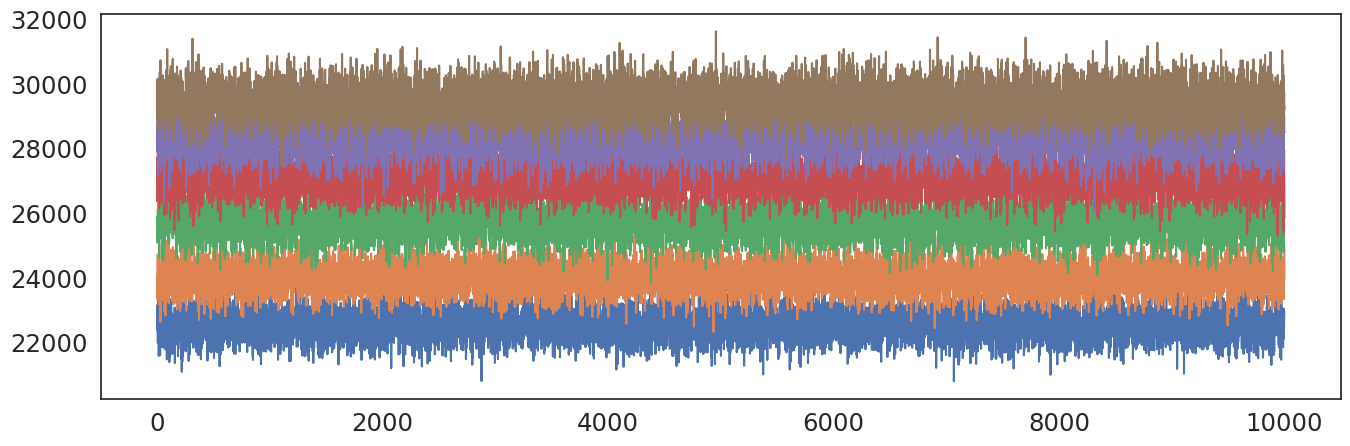

In [18]:
depth = 1
method = 'Flat-STR'

res[method] = []
opts = {
    'num_steps': 200_000,
    'batch_size': 512,
    'num_samples': 100,
    'num_particles': 16,
    'lr': 1e-3,
    'gamma0': 0.2,
    'tau0': 1.  # irrelevant param
}

losses = []
for width_size in num_hn:
    rng_key, _rng_key = random.split(rng_key)
    measurments, smpl, loss = posterior_estimate(rng_key, depth, width_size, BMRRegression, opts, posterior='matrixnormal', method=method)
    losses.append(loss)
    res[method].append( (depth, width_size, measurments, opts, smpl) )

jnp.savez('comp_images.npz', results=res)
plt.figure(figsize=(16, 5))
for loss in losses:
    plt.plot(loss[-10_000:])

In [9]:
depth = 1
opts = {
    'epochs': 1,
    'num_steps1': 180_000,
    'num_steps2': 20_000,
    'batch_size': 512,
    'num_samples': 100,
    'num_particles': 16,
    'lr': 1e-3,
    'gamma0': 0.1,
    'tau0': 1e-2
}

for method in ['BMR-FF']:
    res[method] = []

losses = []
for nh in num_hn:
    print(depth, nh)
    rng_key, _rng_key = random.split(rng_key)
    dense_net = MLP(in_size, out_size=out_size, width_size=nh, depth=depth, key=_rng_key)

    rng_key, _rng_key = random.split(rng_key)
    out, smpl, loss = loopy_bmr(_rng_key, train_ds['label'], dense_net, opts)

    losses.append(loss[-1][-1])
    res['BMR-FF'].append( (depth, nh, out, opts, smpl) )

jnp.savez('comp_images.npz', results=res)
plt.figure(figsize=(16, 5))
for loss in losses:
    plt.plot( loss[-1_000:] )

1 50


100%|██████████| 20000/20000 [00:32<00:00, 619.40it/s, init loss: 10765.3994, avg. loss [19001-20000]: -456.9388]


0.77856445 -5044.37060546875 0.82699996 0.038986675
1 100


100%|██████████| 20000/20000 [00:25<00:00, 790.93it/s, init loss: 12976.2598, avg. loss [19001-20000]: -363.7552]


-0.017913818 -5212.15478515625 0.81589997 0.04992668
1 200


100%|██████████| 20000/20000 [00:34<00:00, 574.55it/s, init loss: 16909.3301, avg. loss [19001-20000]: -477.9137]


0.5029602 -4673.826171875 0.8347 0.025963608
1 300


 23%|██▎       | 42110/180000 [02:44<08:37, 266.66it/s, init loss: 865786.6250, avg. loss [27001-36000]: 31684.8281]

In [ ]:
depth = 1
opts = {
    'epochs': 1,
    'num_steps1': 180_000,
    'num_steps2': 20_000,
    'batch_size': 512,
    'num_samples': 100,
    'num_particles': 16,
    'lr': 1e-3,
    'gamma0': 0.1,
    'tau0': 1e-2
}

method = 'BMR-STR'
res[method] = []

losses = []
for nh in num_hn:
    print(depth, nh)
    rng_key, _rng_key = random.split(rng_key)
    dense_net = MLP(in_size, out_size=out_size, width_size=nh, depth=depth, key=_rng_key)

    rng_key, _rng_key = random.split(rng_key)
    out, smpl, loss = loopy_bmr(_rng_key, train_ds['label'], dense_net, opts, posterior='matrixnormal', autoguide='multivariate', reduced=True)

    losses.append(loss[-1][-1])
    res[method].append( (depth, nh, out, opts, smpl) )

jnp.savez('comp_images.npz', results=res)
plt.figure(figsize=(16, 5))
for loss in losses:
    plt.plot( loss[-1_000:] )

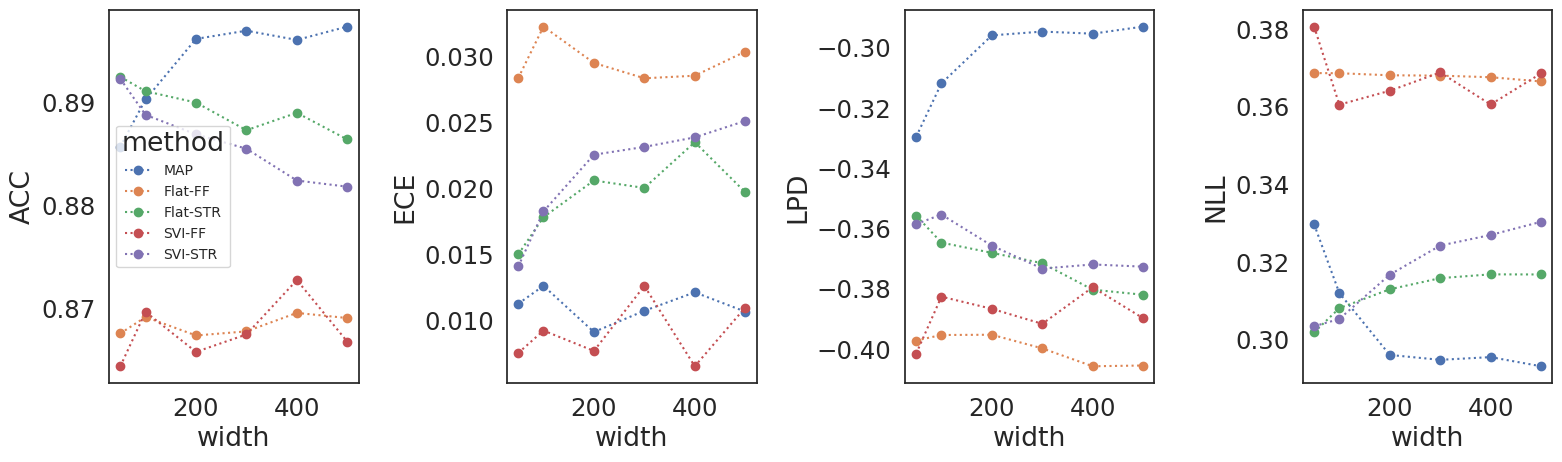

In [10]:
import pandas as pd
fig, axes = plt.subplots(1, 4, figsize=(16, 5), sharex=False)

for key in ['MAP', 'Flat-FF', 'Flat-STR', 'SVI-FF', 'SVI-STR']:

    for i, metric in enumerate(['accs', 'eces', 'lpds', 'nlls']):
        width = [tmp[1] for tmp in res[key]]
        values = [tmp[2][metric][0] for tmp in res[key]]
        axes[i].plot(width, values, 'o:', label=key)
        axes[i].set_xlabel('width')
        axes[i].set_ylabel(metric[:-1].upper())

axes[0].legend(title='method', fontsize=10)
fig.tight_layout()

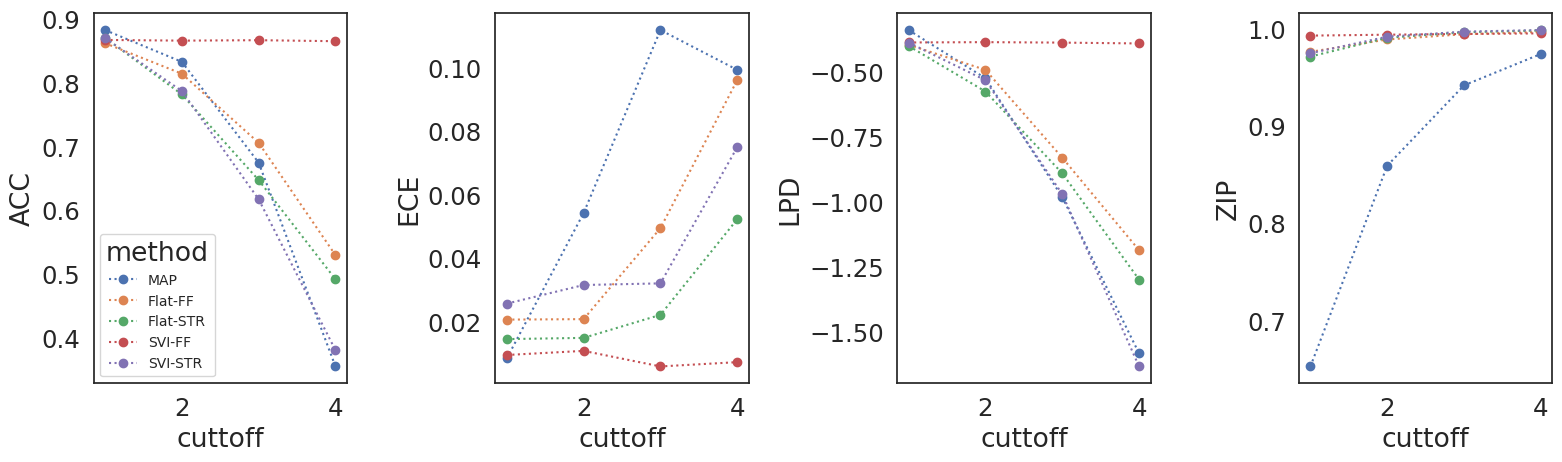

In [11]:
import pandas as pd
fig, axes = plt.subplots(1, 4, figsize=(16, 5), sharex=False)

for key in ['MAP', 'Flat-FF', 'Flat-STR', 'SVI-FF', 'SVI-STR']:
    
    depth, nh, output, opts, smpl = res[key][-1]
    cuttoffs = output['cuttoffs']
    for i, label, method in zip(range(4), ['acc', 'ece', 'lpd', 'zip'], [output['accs'], output['eces'], output['lpds'], output['zips']]):
        axes[i].plot(cuttoffs[1:5], method[1:5], 'o:', label=key)
        axes[i].set_xlabel('cuttoff')
        axes[i].set_ylabel(label.upper())

axes[0].legend(title='method', fontsize=10)
fig.tight_layout()

In [8]:
try:
    res = jnp.load('comp_images_depth.npz', allow_pickle=True)['results'].item()
except:   
    res = {
        'MAP': [],
        'NUTS': [],
        'SVI': [],
        'No-BMR': [],
        'BMR': [],
    }

In [ ]:
def optimizer(learning_rate, steps):
    return optax.chain(
        optax.clip_by_global_norm(1e2),
        optax.adabelief(learning_rate)
    )

method = 'MAP'
res[method] = []
opts = {
    'num_steps': 200_000,
    'batch_size': 512,
    'num_samples': 1,
    'lr': 1e-4,
    'gamma0': 1.
}

optim = lambda learning_rate: optimizer(learning_rate, 100)

losses = []
nh = 100
for depth in [1, 2, 3, 4, 5]:
    print(depth, nh)
    rng_key, _rng_key = random.split(rng_key)
    dense_net = MLP(in_size, out_size=out_size, width_size=nh, depth=depth, key=_rng_key)

    rng_key, _rng_key = random.split(rng_key)
    map_reg = BMRRegression(
        _rng_key, 
        X, 
        dense_net,
        batch_size=opts['batch_size'], 
        regtype='multinomial',
        gamma0=opts['gamma0'],
        posterior='delta',
        optimizer=optim
    )
    
    map_reg.fit(
        train_ds['label'],
        num_samples=opts['num_samples'], 
        num_steps=opts['num_steps'],
        progress_bar=True,
        opt_kwargs={'learning_rate': opts['lr']}
    )

    losses.append(map_reg.results.losses)
    
    map_reg.samples.pop('obs')    
    map_reg.set_input(X_test)

    zipped_smpl, fraction = compression(len(map_reg.layers), map_reg.samples, cuttoff=1e-2)

    rng_key, _rng_key = random.split(rng_key)
    out = test_smpl(_rng_key, map_reg.model, zipped_smpl, test_ds['label'])
    out['DF'] = map_reg.results.losses[-10000:-5000].mean() - map_reg.results.losses[-5000:].mean()
    out['zip'] = fraction
    res[method].append( (depth, nh, out, opts, map_reg.samples) )
    print(out['DF'], out['lpd'], out['acc'], out['ece'], out['zip'])

jnp.savez('comp_images_depth.npz', results=res)
plt.figure(figsize=(16, 5))
for loss in losses:
    plt.plot(loss[-10_000:])

2023-03-17 16:42:58.361384: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:606] fastpath_data is none
2023-03-17 16:43:06.549141: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:606] fastpath_data is none


1 100 1.578125 -4642.6025390625 0.8556 0.006235555 0.9615143
2 100 3.796875 -4281.83740234375 0.86109996 0.010676409 0.9623479
3 100 23.808594 -4209.04443359375 0.86179996 0.0094274925 0.96228063
4 100 13.574219 -4168.5078125 0.8612 0.010373814 0.96072304
5 100 13.5859375 -4231.1728515625 0.8612 0.014351311 0.96158785


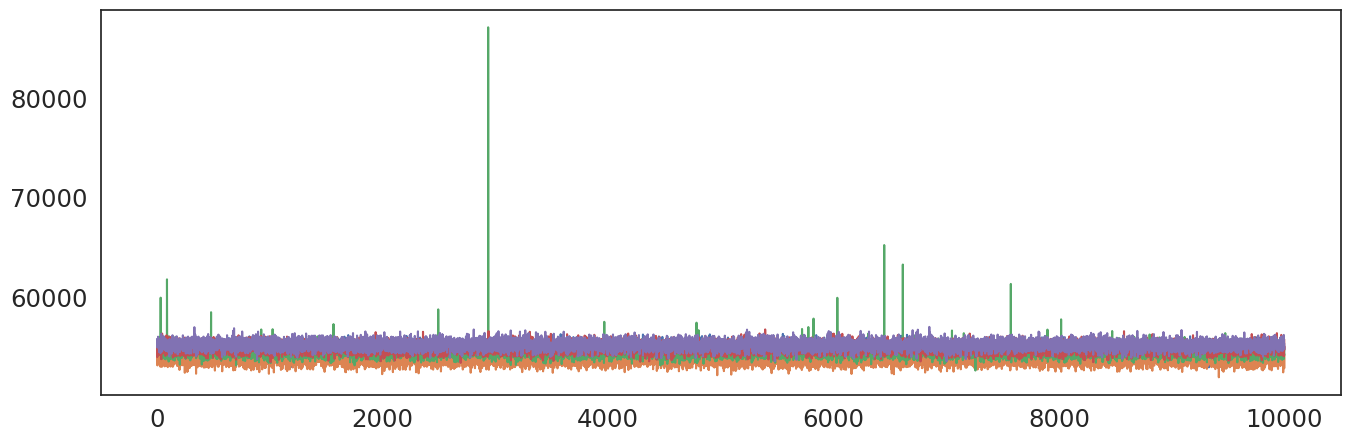

In [ ]:
method = 'SVI'
res[method] = []
opts = {
    'num_steps': 200_000,
    'batch_size': 512,
    'num_samples': 100,
    'num_particles': 10,
    'lr': 1e-3
}

nh = 100
losses = []
for depth in [1, 2, 3, 4, 5]:
    rng_key, _rng_key = random.split(rng_key)
    dense_net = MLP(in_size, out_size=out_size, width_size=nh, depth=depth, key=_rng_key)

    rng_key, _rng_key = random.split(rng_key)
    svi_reg = SVIRegression(
        _rng_key, 
        X, 
        dense_net,
        batch_size=opts['batch_size'], 
        regtype='multinomial'
    )
    
    smpl = svi_reg.fit(
        train_ds['label'], 
        num_samples=opts['num_samples'], 
        num_steps=opts['num_steps'],
        num_particles=opts['num_particles'],
        autoguide='mean-field',
        opt_kwargs={'learning_rate': opts['lr']}
    )

    losses.append(svi_reg.results.losses)

    smpl.pop('obs')
    svi_reg.set_input(X_test)

    zipped_smpl, fraction = compression(len(svi_reg.layers), smpl, cuttoff=2.)

    rng_key, _rng_key = random.split(rng_key)
    out = test_smpl(_rng_key, svi_reg.model, zipped_smpl, test_ds['label'])
    out['DF'] = svi_reg.results.losses[-10000:-5000].mean() - svi_reg.results.losses[-5000:].mean()
    out['zip'] = fraction
    res[method].append( (depth, nh, out, opts, smpl) )
    print(depth, nh, out['DF'], out['lpd'], out['acc'], out['ece'], out['zip'])

    del svi_reg

jnp.savez('comp_images_depth.npz', results=res)
plt.figure(figsize=(16, 5))
for loss in losses:
    plt.plot( loss[-10_000:] )

In [20]:
svi_reg = SVIRegression(
    _rng_key, 
    X, 
    dense_net,
    batch_size=opts['batch_size'], 
    regtype='multinomial'
)

smpls = Predictive(svi_reg.model, num_samples=100)(_rng_key)

100%|██████████| 200000/200000 [07:28<00:00, 446.02it/s, init loss: 386816.2188, avg. loss [190001-200000]: 34785.5234]


1 100 -16.519531 -5717.48583984375 0.8231 0.025463497 0.9350019


100%|██████████| 200000/200000 [08:29<00:00, 392.30it/s, init loss: 368170.3125, avg. loss [190001-200000]: 35538.9570]


2 100 -5.4335938 -5777.7587890625 0.8215 0.027868941 0.9441022


100%|██████████| 200000/200000 [09:44<00:00, 341.89it/s, init loss: 357512.0625, avg. loss [190001-200000]: 35281.3398]


3 100 -0.78125 -5944.349609375 0.8114 0.034691826 0.9487815


100%|██████████| 200000/200000 [11:30<00:00, 289.54it/s, init loss: 359484.6250, avg. loss [190001-200000]: 35702.4922]


4 100 3.2929688 -6212.525390625 0.80429995 0.022118207 0.9512886


100%|██████████| 200000/200000 [12:57<00:00, 257.26it/s, init loss: 375182.5938, avg. loss [190001-200000]: 36182.2578]


5 100 8.160156 -6771.19873046875 0.7966 0.028379606 0.95711786


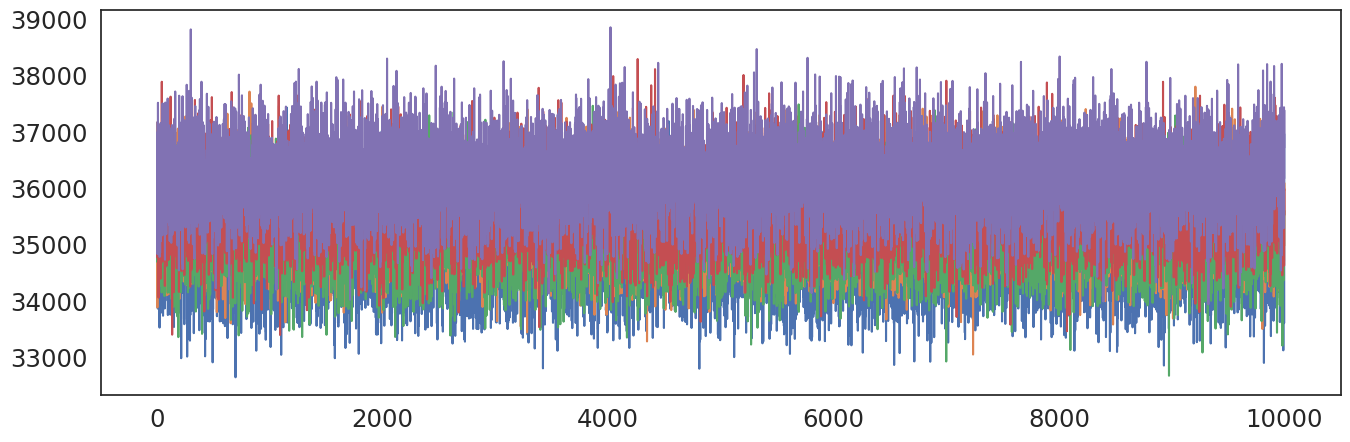

In [35]:
method = 'No-BMR'
res[method] = []
opts = {
    'num_steps': 200_000,
    'batch_size': 512,
    'num_samples': 100,
    'num_particles': 10,
    'lr': 1e-3,
    'gamma0': 0.2
}

nh = 100
losses = []
for depth in [1, 2, 3, 4, 5]:
    rng_key, _rng_key = random.split(rng_key)
    dense_net = MLP(in_size, out_size=out_size, width_size=nh, depth=depth, key=_rng_key)

    rng_key, _rng_key = random.split(rng_key)
    bmr_reg = BMRRegression(
        _rng_key, 
        X, 
        dense_net, 
        regtype='multinomial',
        batch_size=opts['batch_size'],
        posterior='normal',
        gamma0=opts['gamma0']
    )
    
    smpl = bmr_reg.fit(
        train_ds['label'], 
        num_samples=opts['num_samples'], 
        num_steps=opts['num_steps'],
        num_particles=opts['num_particles'],
        progress_bar=True,
        opt_kwargs={'learning_rate': opts['lr']}
    )

    losses.append(bmr_reg.results.losses)

    smpl.pop('obs')
    bmr_reg.set_input(X_test)

    zipped_smpl, fraction = compression(len(bmr_reg.layers), smpl, cuttoff=2.)

    rng_key, _rng_key = random.split(rng_key)
    out = test_smpl(_rng_key, bmr_reg.model, zipped_smpl, test_ds['label'])
    out['DF'] = bmr_reg.results.losses[-10000:-5000].mean() - bmr_reg.results.losses[-5000:].mean()
    out['zip'] = fraction
    res[method].append( (depth, nh, out, opts, smpl) )
    print(depth, nh, out['DF'], out['lpd'], out['acc'], out['ece'], out['zip'])

    del bmr_reg

jnp.savez('comp_images_depth.npz', results=res)
plt.figure(figsize=(16, 5))
for loss in losses:
    plt.plot( loss[-10_000:] )

In [17]:
def loopy_bmr(rng_key, y, nnet, opts):
    rng_key, _rng_key = random.split(rng_key)
    bmr_reg = BMRRegression(
        _rng_key, 
        X, 
        nnet, 
        regtype='multinomial',
        batch_size=opts['batch_size'],
        posterior='normal',
        gamma0=opts['gamma0']
    )

    losses = []

    for e in range(opts['epochs']):
        bmr_reg.set_input(X, opts['batch_size'])
        
        bmr_reg.fit(
            y, 
            num_samples=1, 
            num_steps=opts['num_steps1'],
            num_particles=opts['num_particles'],
            progress_bar=False,
            opt_kwargs={'learning_rate': opts['lr']}
        )
        bmr_reg.samples.pop('obs')

        results, smpl = bmr_reg.bmr(
            'mean-field', 
            num_steps=opts['num_steps2'], 
            progress_bar=False,
            num_particles=opts['num_particles'], 
            num_samples=opts['num_samples'],
            opt_kwargs={'learning_rate': opts['lr']} 
        )

        losses.append((bmr_reg.results.losses, results.losses))

        smpl.pop('obs')
        bmr_reg.set_input(X_test)

        zipped_smpl, fraction = compression(len(bmr_reg.layers), smpl, cuttoff=2.)

        rng_key, _rng_key = random.split(rng_key)
        out = test_smpl(_rng_key, bmr_reg.model, zipped_smpl, test_ds['label'])
        out['DF'] = results.losses[-1000:-500].mean() - results.losses[-500:].mean()
        out['zip'] = fraction
        
        print(out['DF'], out['lpd'], out['acc'], out['ece'], fraction)            

    return out, smpl, losses

In [21]:
opts = {
    'epochs': 10,
    'num_steps1': 10_000,
    'num_steps2': 10_000,
    'batch_size': 512,
    'num_samples': 100,
    'num_particles': 10,
    'lr': 1e-3,
    'gamma0': 0.2
}

for method in ['BMR']:
    res[method] = []

nh = 100
for depth in [1, 2, 3, 4, 5]:
    print(depth, nh)
    rng_key, _rng_key = random.split(rng_key)
    dense_net = MLP(in_size, out_size=out_size, width_size=nh, depth=depth, key=_rng_key)

    rng_key, _rng_key = random.split(rng_key)
    out, smpl, losses = loopy_bmr(_rng_key, train_ds['label'], dense_net, opts)

    res['BMR'].append( (depth, nh, out, opts, smpl) )

jnp.savez('comp_images_depth.npz', results=res)

fig.tight_layout()

1 100
11.0625 -6477.44482421875 0.797 0.007724742 0.922777
5.7851562 -5372.66357421875 0.8251 0.0059718164 0.9370645
14.716797 -5210.63427734375 0.8362 0.015468809 0.93656147
7.7714844 -4926.33056640625 0.8454 0.011366751 0.9355553
10.216797 -4975.5166015625 0.84239995 0.01718247 0.92105395
11.6640625 -4890.85302734375 0.8487 0.013179307 0.9309395
13.302734 -4756.30908203125 0.8459 0.0149973 0.9400956
8.318359 -4712.93310546875 0.8488 0.015135205 0.9357188
5.71875 -4679.548828125 0.8491 0.014276762 0.9397057
-0.43945312 -4683.86328125 0.8477 0.010349085 0.9362847
2 100
9.082031 -7173.59814453125 0.75589997 0.027007457 0.9412566
15.564453 -5263.5908203125 0.8305 0.010197354 0.93898004
6.7617188 -4944.71142578125 0.84209996 0.013959659 0.93979466
18.732422 -4652.05078125 0.8506 0.011688341 0.93475056
16.128906 -4665.14501953125 0.85349995 0.011957876 0.9381542
15.384766 -4593.02392578125 0.849 0.017487062 0.93267494
10.386719 -4707.8203125 0.84749997 0.020541642 0.9416471
15.125 -4667.78

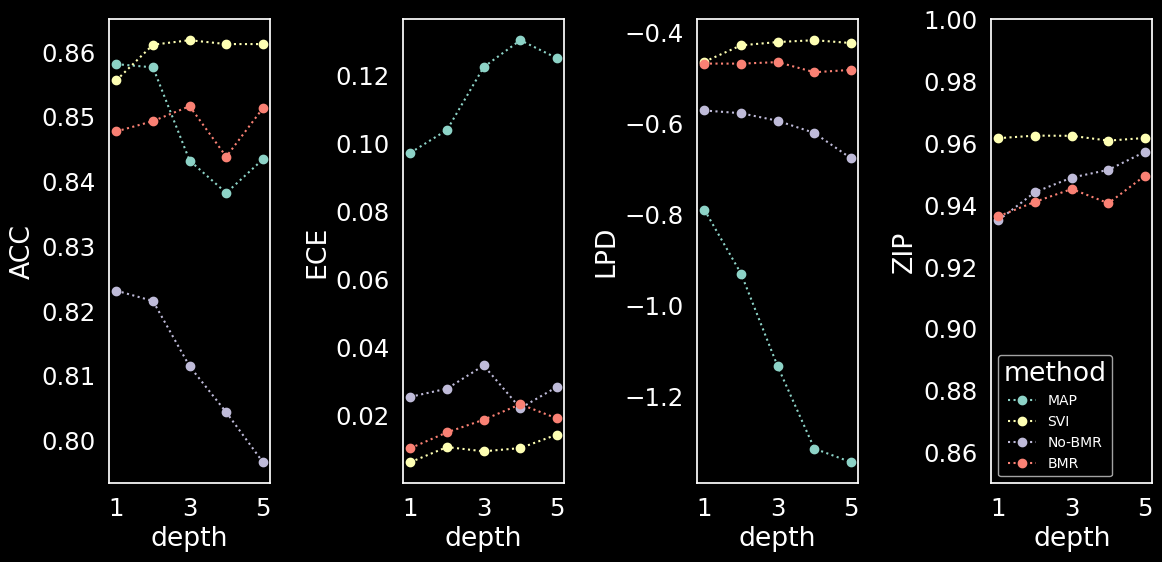

In [17]:
import pandas as pd
fig, axes = plt.subplots(1, 4, figsize=(12, 6), sharex=False)

for key in ['MAP', 'SVI', 'No-BMR', 'BMR']:

    for i, metric in enumerate(['acc', 'ece', 'lpd']):
        if metric == 'lpd':
            axes[i].plot([tpl[0] for tpl in res[key]], [tpl[2][metric]/10_000 for tpl in res[key]], 'o:', label=key)
        else:
            axes[i].plot([tpl[0] for tpl in res[key]], [tpl[2][metric] for tpl in res[key]], 'o:', label=key)
        axes[i].set_xlabel('depth')
        axes[i].set_ylabel(metric.upper())

for key in ['MAP', 'SVI', 'No-BMR', 'BMR']:
    metric = 'zip'
    axes[-1].plot([tpl[0] for tpl in res[key]], [tpl[2][metric] for tpl in res[key]], 'o:', label=key)
    axes[-1].set_xlabel('depth')
    axes[-1].set_ylabel(metric.upper())

axes[-1].legend(title='method', fontsize=10)
axes[-1].set_ylim([0.85, 1])
for i in range(4):
    axes[i].set_xticks([1, 3, 5])
fig.tight_layout()
fig.savefig('Fig5.png', bbox_inches='tight', transparent=True,  dpi=300)

In [87]:
#TODO Plot performance depending on the z-score based prunning